In [1]:
import numpy as np
import torch
import cv2
import seaborn as sns
import sys
sys.path.append('..')

from models import model_dict
from helper.sampling import langevin_at_x

# Get model and replay buffer

In [3]:
!ls /data/lijingru/EBKD/save/student_model/resnet28x10_cifar100_lr_0.0003_decay_0_buffer_size_20000_lpx_1.0_lpxy_0.0_energy_mode_mcmc_step_size_1_g_steps_20_trial_7

hyper  img_samples  res_epoch_160.pts


In [4]:
!nvidia-smi

Tue Dec  7 15:00:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.67       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:04:00.0 Off |                  N/A |
| 30%   31C    P8    25W / 350W |   1675MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:05:00.0 Off |                  N/A |
| 30%   

| Wide-Resnet 28x10


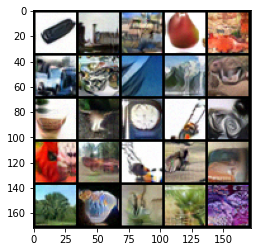

In [5]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
device = "cuda:4"
model = model_dict['resnet28x10'](num_classes=100, norm='none', depth=28, widen_factor=10)
model = model_dict['Gen'](model, n_cls=100)
model = model.to(device)
save_path = '/data/lijingru/EBKD/save/student_model/resnet28x10_cifar100_lr_0.0003_decay_0_buffer_size_20000_lpx_1.0_lpxy_0.0_energy_mode_mcmc_step_size_1_g_steps_20_trial_7/'
ckpt_dict = torch.load(save_path + 'res_epoch_160.pts', map_location=device)
model.load_state_dict(ckpt_dict["model_state_dict"])
replay_buffer = ckpt_dict["replay_buffer"]
sqrt = lambda x: int(torch.sqrt(torch.tensor([x])))
plot = lambda x: vutils.make_grid(torch.clamp(x, -1, 1), normalize=True, nrow=sqrt(x.size(0)))
buffer_size = len(replay_buffer)
inds = torch.randint(0, buffer_size, (25,))
sampled = replay_buffer[inds]
imgs = plot(sampled).cpu()
img = np.transpose(imgs, (1,2,0))
plt.figure(10)
plt.imshow(img)

### Calculate Inception Score and Options

In [6]:
import os
# save_path = '/data/lijingru/EBKD/save/student_model/resnet8x4_cifar100_lr_0.0001_decay_0.0_buffer_size_40000_lpx_0.0_lpxy_1.0_energy_mode_mcmc_step_size_5.0_trial_2_cls/'
if not os.path.exists(save_path):
    os.mkdir(save_path)



class Options:
    def __init__(self, save_grid=False):
        self.n_cls = 100
        self.save_folder = save_path
        if not save_grid:
            self.save_dir = os.path.join(save_path, 'img_sample_eval/')
        else:
            self.save_dir = os.path.join(save_path, 'img_sample_eval_grid/')
        self.save_grid = save_grid
        self.reinit_freq = 0.05
        self.batch_size = 64
        self.step_size = 1
        self.buffer_size = 20000
        self.n_sample_steps = 5
        self.print_every = 100
        self.dataset = 'svhn'
        self.g_steps = 40
#         self.reinit_freq = 0.
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

        
opt = Options()

replay_buffer.size(0) / opt.n_cls

200.0

## Visualize sample q
The visualization of $x \sim q_{\theta}$.

In [5]:
sample_q, _ = langevin_at_x(opt)
f_sample, samples = sample_q(model, replay_buffer, open_debug=True)
samples = torch.cat(samples, 0).cpu()
imgs = plot(samples)
img = np.transpose(imgs, (1,2,0))
plt.figure(10)
plt.imshow(img)

RuntimeError: Expected tensor for argument #1 'input' to have the same device as tensor for argument #2 'weight'; but device 0 does not equal 1 (while checking arguments for cudnn_convolution)

In [7]:
!rm -rf /data/lijingru/EBKD/save/student_model/cifar100_resnet28x10_cifar100_lr_0.0001_decay_0_buffer_size_10000_lpx_1.0_lpxy_0.0_energy_mode_mcmc_step_size_1_trial_short_refresh/img_sample_eval/

In [7]:
from helper.util_gen import cond_samples
opt = Options()
if not os.path.exists(opt.save_dir):
    os.mkdir(opt.save_dir)
# model.cuda()
cond_samples(model, replay_buffer, device, opt, use_buffer=True)

100%|██████████| 100/100 [04:25<00:00,  2.65s/it]


Successfully saving the generated result of replay buffer.
Successfully save the result.


tensor([[[[ 0.9887,  0.8714,  0.9192,  ...,  0.6450,  0.6160,  0.6228],
          [ 0.9563,  0.7521,  0.7622,  ...,  0.6577,  0.6237,  0.7065],
          [ 0.9604,  0.8261,  0.6764,  ...,  0.6832,  0.6988,  0.7314],
          ...,
          [ 0.7271,  0.7244,  0.5546,  ...,  0.5827,  0.5780,  0.5774],
          [ 0.7615,  0.6181,  0.5622,  ...,  0.5409,  0.5400,  0.5907],
          [ 0.6233,  0.6125,  0.6255,  ...,  0.4843,  0.5231,  0.5111]],

         [[ 0.8409,  0.7017,  0.5241,  ...,  0.0293,  0.0151,  0.2108],
          [ 0.7537,  0.6470,  0.4606,  ...,  0.1811,  0.1878,  0.2771],
          [ 0.6576,  0.4615,  0.3119,  ...,  0.5349,  0.5599,  0.4852],
          ...,
          [ 0.4985,  0.4992,  0.4483,  ...,  0.5300,  0.6317,  0.5963],
          [ 0.5864,  0.4213,  0.4924,  ...,  0.5394,  0.5997,  0.5817],
          [ 0.5283,  0.4700,  0.4972,  ...,  0.5079,  0.5580,  0.4736]],

         [[ 0.8324,  0.6776,  0.5133,  ..., -0.3102, -0.1197, -0.1204],
          [ 0.7320,  0.5757,  

In [8]:
from helper.util import inception_score
from datasets.cifar100 import CIFAR100Gen
import torchvision.transforms as T
if not opt.save_grid:
    test_folder = opt.save_dir
    dataset = CIFAR100Gen(
        root=test_folder,
        transform=T.Compose([
            T.ToTensor(),
            T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])
    )
    mean, var = inception_score(dataset, device, resize=True, splits=3, batch_size=8)
    print(mean, var)
    
# print(os.listdir(test_folder))
print(len(os.listdir(test_folder)))

/data/lijingru/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


6.5239644588791315 0.08108719885256184
20000


In [9]:
os.listdir(test_folder)

['samples_label_8_60.png',
 'samples_label_17_11.png',
 'samples_label_55_37.png',
 'samples_label_1_65.png',
 'samples_label_98_15.png',
 'samples_label_66_81.png',
 'samples_label_6_60.png',
 'samples_label_91_34.png',
 'samples_label_31_22.png',
 'samples_label_7_73.png',
 'samples_label_5_20.png',
 'samples_label_14_13.png',
 'samples_label_75_56.png',
 'samples_label_26_15.png',
 'samples_label_97_31.png',
 'samples_label_52_74.png',
 'samples_label_81_73.png',
 'samples_label_69_60.png',
 'samples_label_41_20.png',
 'samples_label_52_22.png',
 'samples_label_43_123.png',
 'samples_label_92_31.png',
 'samples_label_87_61.png',
 'samples_label_29_15.png',
 'samples_label_94_27.png',
 'samples_label_99_49.png',
 'samples_label_95_66.png',
 'samples_label_56_68.png',
 'samples_label_81_53.png',
 'samples_label_62_68.png',
 'samples_label_32_78.png',
 'samples_label_17_7.png',
 'samples_label_73_74.png',
 'samples_label_81_58.png',
 'samples_label_90_85.png',
 'samples_label_53_35.png

In [15]:
# print(len(os.listdir(test_folder)))
from helper.util_gen import cond_samples
test_folder = opt.save_dir
print(test_folder)

optd = Options(save_grid=True)
cond_samples(model, replay_buffer, device, optd)

/data/lijingru/EBKD/save/student_model/cifar100_resnet28x10_cifar100_lr_0.0001_decay_0_buffer_size_10000_lpx_1.0_lpxy_0.0_energy_mode_mcmc_step_size_1_trial_short_refresh/img_sample_eval/


100%|██████████| 100/100 [00:04<00:00, 22.82it/s]

Successfully saving the generated result of replay buffer.


tensor([[[[ 1.0513e+00,  9.8224e-01,  9.6862e-01,  ...,  9.1669e-01,
            1.0614e+00,  1.4637e+00],
          [ 1.0047e+00,  9.3634e-01,  9.9040e-01,  ...,  8.0460e-01,
            1.0694e+00,  9.6850e-01],
          [ 1.0008e+00,  9.9291e-01,  9.5258e-01,  ...,  6.9197e-01,
            7.4473e-01,  8.3951e-01],
          ...,
          [ 1.0424e+00,  9.8448e-01,  8.2598e-01,  ...,  9.9922e-01,
            9.5964e-01,  9.5444e-01],
          [ 1.0386e+00,  9.4207e-01,  9.1723e-01,  ...,  9.9627e-01,
            9.6662e-01,  9.6769e-01],
          [ 1.3081e+00,  1.0199e+00,  9.7416e-01,  ...,  9.1009e-01,
            1.0027e+00,  1.1993e+00]],

         [[ 9.5454e-01,  9.7141e-01,  9.8044e-01,  ...,  1.0712e+00,
            1.2699e+00,  1.0907e+00],
          [ 1.0342e+00,  9.5942e-01,  9.6847e-01,  ...,  9.6750e-01,
            1.1363e+00,  1.2032e+00],
          [ 9.9090e-01,  9.6447e-01,  9.6487e-01,  ...,  7.6949e-01,
            8.5691e-01,  1.2097e+00],
          ...,
     

### t-SNE visualization

## Set options, datasets and dataloaders

In [9]:
from datasets.cifar100 import CIFAR100Gen, CIFAR100Instance
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from PIL import Image

test_folder = '/data/lijingru/cifar100/'
test_gen_folder = '/data/lijingru/img_sample_eval/'


test_list = [
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]


# train_transform = transforms.Compose(train_list)
test_transform = transforms.Compose(test_list)
test_positive_set = CIFAR100Instance(root=test_folder, download=True, train=False, transform=test_transform)
test_negative_set = CIFAR100Gen(root=opt.save_dir, transform=test_transform, return_target=True)

test_p_loader = DataLoader(dataset=test_positive_set, batch_size=1, shuffle=False, num_workers=8)
test_n_loader = DataLoader(dataset=test_negative_set, batch_size=1, shuffle=False, num_workers=8)

Files already downloaded and verified


In [10]:
import tqdm
model.eval()
p_energys = []
q_energys = []
correct = 0
p_predict = []
for idx, data in tqdm.tqdm(enumerate(test_p_loader)):
    x, y, i = data
    x = x.to(device)
    y = y.to(device)
    logit = model(x=x, cls_mode=True)
    indexs = torch.argmax(logit, 1)
    p_predict += indexs.tolist()
    b_correct = torch.sum(indexs == y).item()
    correct += b_correct
    f = torch.gather(logit, 1, y[:, None]).mean()
    
    f = model(x=x, y=y)[0].mean()
    p_energys.append(f.item())
    
print('Positive Samples:')
print('Max: {:.4f}'.format(max(p_energys)))
print('Min: {:.4f}'.format(min(p_energys)))
print('Mean: {:.4f}'.format(sum(p_energys) / len(p_energys)))
print('Acc: {:.4f}'.format(correct / len(test_p_loader)))

for idx, data in tqdm.tqdm(enumerate(test_n_loader)):
    x, y, i = data
    x = x.to(device)
    y = y.to(device)
    
    f = model(x=x, y=y)[0].mean()
    q_energys.append(f.item())
    


print('Negative Samples:')
print('Max: {:.4f}'.format(max(q_energys)))
print('Min: {:.4f}'.format(min(q_energys)))
print('Mean: {:.4f}'.format(sum(q_energys) / len(q_energys)))

10000it [02:18, 72.30it/s]

Positive Samples:
Max: 13.0448
Min: -14.1945
Mean: 0.4122
Acc: 0.5900



50000it [06:23, 130.33it/s]

Negative Samples:
Max: 13.6658
Min: -13.3723
Mean: 1.2799


In [11]:
np.save(os.path.join(opt.save_folder, 'pxy_energy.npy'), np.asarray(p_energys))
np.save(os.path.join(opt.save_folder, 'qxy_energy.npy'), np.asarray(q_energys))

## Plot the distribution of energy function
$x^+ \sim p_{data}$, and $x^- \sim q_{\theta}$. If the EBM is well-trained, the plotted distribution should be close enough.

Here presented the distribution of conditional generation $p_{\theta}(x | y)$.

In [12]:
# If you have saved the energy value..
p_energys = np.load(os.path.join(opt.save_folder, 'pxy_energy.npy'))
q_energys = np.load(os.path.join(opt.save_folder, 'qxy_energy.npy'))

<AxesSubplot:ylabel='Density'>

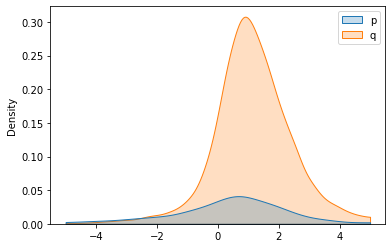

In [13]:
sns.kdeplot(data={'p':p_energys, 'q':q_energys}, clip=(-5, 5), fill=True)

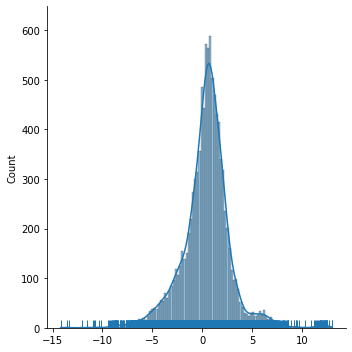

In [14]:
sns.displot(x=p_energys, kde=True, rug=True)

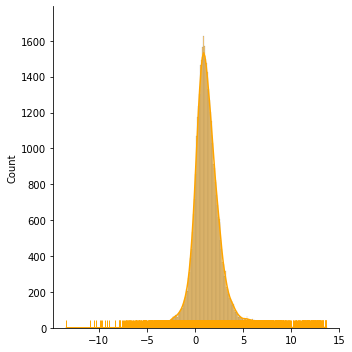

In [15]:
sns.displot(x=q_energys, color='orange', rug=True, kde=True)

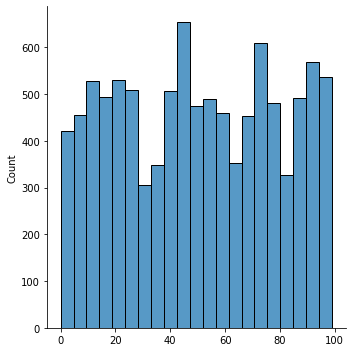

In [16]:
sns.displot(x=p_predict)

## Unconditional energy distribution
Considering the distribution of unconditional generation $p_{\theta}(x)$.

In [17]:
model.eval()
p_energys = []
q_energys = []
for idx, data in tqdm.tqdm(enumerate(test_p_loader)):
    x, y, i = data
    x = x.to(device)
    y = y.to(device)
    
    f = model(x=x)[0].mean()
    p_energys.append(f.item())
    
print('Positive Samples:')
print('Max: {:.4f}'.format(max(p_energys)))
print('Min: {:.4f}'.format(min(p_energys)))
print('Mean: {:.4f}'.format(sum(p_energys) / len(p_energys)))

for idx, data in tqdm.tqdm(enumerate(test_n_loader)):
    x, y, i = data
    x = x.to(device)
    y = y.to(device)
    
    f = model(x=x)[0].mean()
    q_energys.append(f.item())
    


print('Negative Samples:')
print('Max: {:.4f}'.format(max(q_energys)))
print('Min: {:.4f}'.format(min(q_energys)))
print('Mean: {:.4f}'.format(sum(q_energys) / len(q_energys)))

10000it [01:19, 125.61it/s]

Positive Samples:
Max: 13.0448
Min: -8.1076
Mean: 1.9107



50000it [06:35, 126.45it/s]

Negative Samples:
Max: 13.6658
Min: -12.3969
Mean: 1.8319


In [18]:
np.save(os.path.join(opt.save_folder, 'px_energy.npy'), np.asarray(p_energys))
np.save(os.path.join(opt.save_folder, 'qx_energy.npy'), np.asarray(q_energys))

In [19]:
# If you have saved energy value
p_energys = np.load(os.path.join(opt.save_folder, 'px_energy.npy'))
q_energys = np.load(os.path.join(opt.save_folder, 'qx_energy.npy'))

<AxesSubplot:ylabel='Density'>

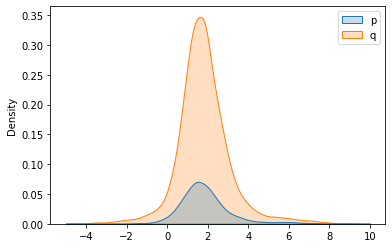

In [20]:
sns.kdeplot(data={'p':p_energys, 'q':q_energys}, clip=(-5, 10), fill=True)

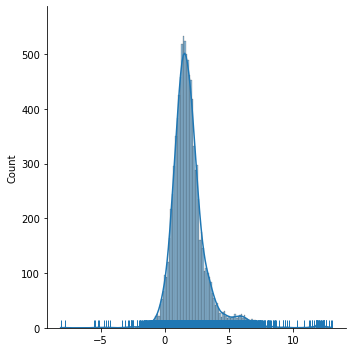

In [21]:
sns.displot(x=p_energys, kde=True, rug=True)

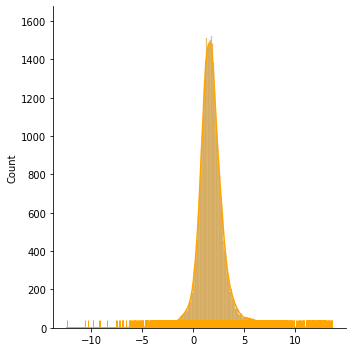

In [22]:
sns.displot(x=q_energys, color='orange', rug=True, kde=True)

In [9]:
f = open(os.path.join(opt.save_folder, 'best.txt'), 'w')
f.write('best_result:{:.4f} +- {:.4f}'.format(mean, var))
f.close()